# QOSF Cohort 9

Zero-noise extrapolation (ZNE) is a noise mitigation technique. It works by intentionally scaling the noise of a quantum circuit to then extrapolate the zero-noise limit of an observable of interest. In this task, you will build a simple ZNE function from scratch:

* Build a simple noise model with depolarizing noise
* Create different circuits to test your noise models and choose the observable to measure
* Apply the unitary folding method.
* Apply the extrapolation method to get the zero-noise limit. Different extrapolation methods achieve different results, such as Linear, polynomial, and exponential.
* Compare mitigated and unmitigated results



Bonus: Run your ZNE function in real quantum hardware through the IBM Quantum Service


## Installation

In [1]:
!pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.7 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 12.0 MB/s eta 0:00:00


In [3]:
!pip install qiskit_ibm_runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 13.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.7 MB/s eta 0:00:00
  Created wheel for ibm-platform-services: filename=ibm_platform_services-0.52.0-py3-none-any.whl size=331902 sha256=c6c3cd7bd7d708124c94771b1ba54e25bac1e38f069df7c9b4f46dc598d83c46
  Stored in directory: /root/.cache/pip/wheels/9b/34/7b/f02968953b977f20d07a36eab5f7ea8c4d6590f5919940a9f8
  Created wheel for ibm-cloud-sdk

## Imports

In [4]:
import numpy as np
import copy
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

## Build a simple noise model with depolarizing noise

In [5]:
def depolarizing_noise_model(p_error_one_qubit, p_error_two_qubit):
    """
    Create a noise model with depolarizing noise on all single-qubit and two-qubit gates.

    Args:
        p_error (float): Probability of error per gate.

    Returns:
        NoiseModel: The depolarizing noise model.
    """
    noise_model = NoiseModel()

    # Depolarizing error on single-qubit gates
    error_single_qubit = depolarizing_error(p_error_one_qubit, 1)

    # Depolarizing error on two-qubit gates
    error_two_qubit = depolarizing_error(p_error_two_qubit, 2)

    # Add the errors to the noise model
    noise_model.add_all_qubit_quantum_error(error_single_qubit, ['rx', 'rz'])
    noise_model.add_all_qubit_quantum_error(error_two_qubit, ['cx'])

    return noise_model

# Example usage
p_error_one_qubit = 0.01
p_error_two_qubit = 0.005
dep_noise_model = depolarizing_noise_model(p_error_one_qubit, p_error_two_qubit)


In [6]:
print(dep_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rx', 'rz', 'sx']
  Instructions with noise: ['rz', 'rx', 'cx']
  All-qubits errors: ['rx', 'rz', 'cx']


## Create different circuits to test your noise models and choose the observable to measure

**Test Circuit 1**

In [7]:
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


**Ideal Simulator**

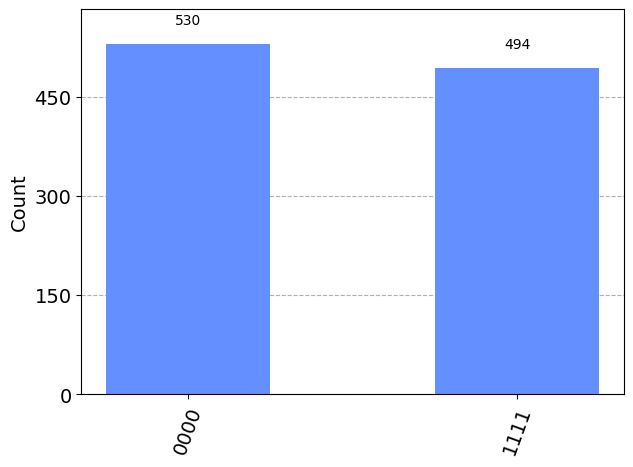

In [8]:
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

**Noise Model**

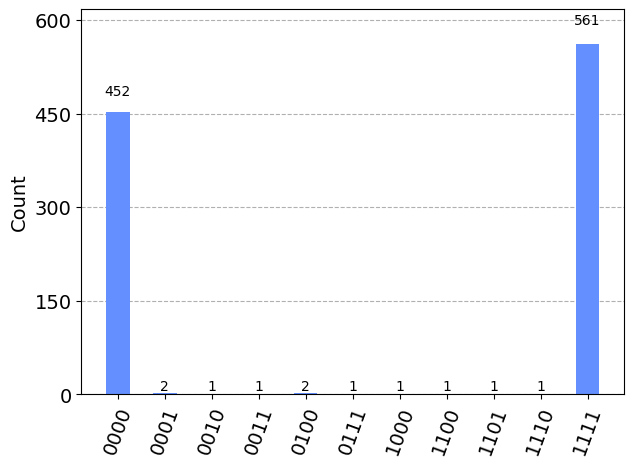

In [9]:
sim_noise = AerSimulator(noise_model=dep_noise_model)

circ_noise = transpile(circ, sim_noise)

result_noise = sim_noise.run(circ_noise).result()
counts_noise = result_noise.get_counts()

# Plot noisy output
plot_histogram(counts_noise)

In [10]:
def probabilities(counts):
    prob = []
    keys = list(counts.keys())
    for j in range(dim):
        if j in keys:
            prob.append(counts[j])
        else:
            prob.append(0)

    prob = np.array(prob)
    prob = prob/np.sum(prob)
    return prob

**Func generating qc**

In [11]:
L = 1
n = 3
dim = 2**n

print(f'number of layers = {L}')
print(f'number of qubits = {n}')

angs = np.pi*np.random.rand(L, n)
print(f'angles = {angs}\n')

def generate_QC(L, n, angs):
    qc = QuantumCircuit(n)
    for l in range(L):
        for i in range(n):
            qc.rz(angs[l, i], i)
        for i in range(n-1):
            qc.cx(i, i+1)
    return qc



circ = generate_QC(L, n, angs)
print(circ)

number of layers = 1
number of qubits = 3
angles = [[1.06679498 0.06161204 1.60786113]]

      ┌────────────┐           
q_0: ─┤ Rz(1.0668) ├───■───────
     ┌┴────────────┴┐┌─┴─┐     
q_1: ┤ Rz(0.061612) ├┤ X ├──■──
     └┬────────────┬┘└───┘┌─┴─┐
q_2: ─┤ Rz(1.6079) ├──────┤ X ├
      └────────────┘      └───┘


**Ideal Simulator**

         ┌────────────┐            ░ ┌─┐      
   q_0: ─┤ Rz(1.0668) ├───■────────░─┤M├──────
        ┌┴────────────┴┐┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ┤ Rz(0.061612) ├┤ X ├──■───░──╫─┤M├───
        └┬────────────┬┘└───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ─┤ Rz(1.6079) ├──────┤ X ├─░──╫──╫─┤M├
         └────────────┘      └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════╩══╩══╩═
                                      0  1  2 


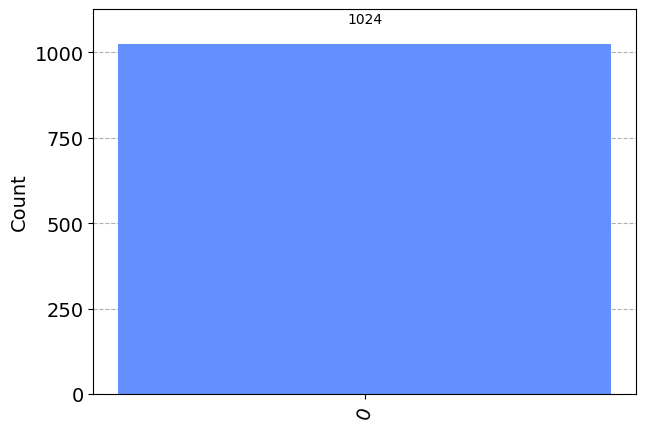

In [12]:
ideal_sim = AerSimulator()

ideal_circ = generate_QC(L, n, angs)
ideal_circ.measure_all()
print(ideal_circ)
result_ideal = ideal_sim.run(ideal_circ).result()
counts_ideal = result_ideal.get_counts()

counts_ideal_dict = {int(z, 2): counts for z, counts in counts_ideal.items()}
plot_histogram(counts_ideal_dict)

**noise model**

         ┌────────────┐            ░ ┌─┐      
   q_0: ─┤ Rz(1.0668) ├───■────────░─┤M├──────
        ┌┴────────────┴┐┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ┤ Rz(0.061612) ├┤ X ├──■───░──╫─┤M├───
        └┬────────────┬┘└───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ─┤ Rz(1.6079) ├──────┤ X ├─░──╫──╫─┤M├
         └────────────┘      └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════╩══╩══╩═
                                      0  1  2 


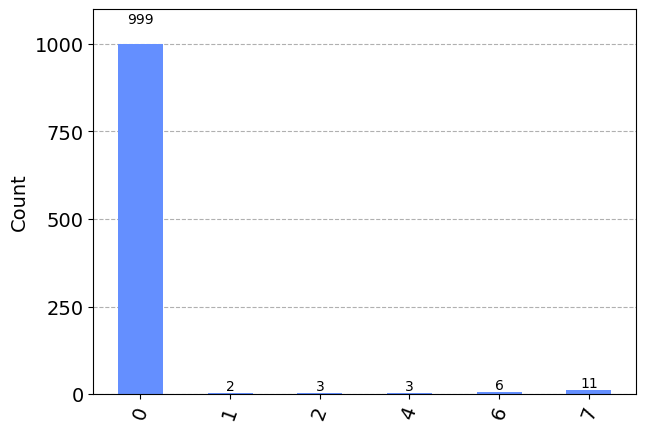

In [13]:
noise_sim = AerSimulator(noise_model=dep_noise_model)

circ_copy = generate_QC(L, n, angs)
circ_copy.measure_all()
print(circ_copy)
result_noise = noise_sim.run(circ_copy).result()
counts_noise = result_noise.get_counts(0)

counts_noise_dict = {int(z, 2): counts for z, counts in counts_noise.items()}
plot_histogram(counts_noise_dict)

## Apply the unitary folding method.

In [14]:
def unitary_folding(k):
    print(f'folding {k} times')
    circ = generate_QC(L, n, angs)
    transpiled = transpile(circ, sim_noise)
    for _ in range(k-1):
        transpiled = transpiled.compose(transpile(circ, sim_noise))

    transpiled.measure_all()
    print(transpiled)
    result_noise = sim_noise.run(transpiled).result()
    counts_noise = result_noise.get_counts()
    counts_noise_int = {int(z, 2): counts for z, counts in counts_noise.items()}
    prob_noise = probabilities(counts_noise_int)
    return prob_noise

## Apply the extrapolation method to get the zero-noise limit.

In [15]:
kmax = 10
ks = range(1, kmax)
prob_noise_list = np.array([unitary_folding(k) for k in ks])

prob_unmitigated_list = np.array([unitary_folding(1) for k in ks])

folding 1 times
         ┌────────────┐            ░ ┌─┐      
   q_0: ─┤ Rz(1.0668) ├───■────────░─┤M├──────
        ┌┴────────────┴┐┌─┴─┐      ░ └╥┘┌─┐   
   q_1: ┤ Rz(0.061612) ├┤ X ├──■───░──╫─┤M├───
        └┬────────────┬┘└───┘┌─┴─┐ ░  ║ └╥┘┌─┐
   q_2: ─┤ Rz(1.6079) ├──────┤ X ├─░──╫──╫─┤M├
         └────────────┘      └───┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════╩══╩══╩═
                                      0  1  2 
folding 2 times
         ┌────────────┐      ┌────────────┐                           ░ ┌─┐   »
   q_0: ─┤ Rz(1.0668) ├───■──┤ Rz(1.0668) ├──────────────────■────────░─┤M├───»
        ┌┴────────────┴┐┌─┴─┐└────────────┘┌──────────────┐┌─┴─┐      ░ └╥┘┌─┐»
   q_1: ┤ Rz(0.061612) ├┤ X ├──────■───────┤ Rz(0.061612) ├┤ X ├──■───░──╫─┤M├»
        └┬────────────┬┘└───┘    ┌─┴─┐     └┬────────────┬┘└───┘┌─┴─┐ ░  ║ └╥┘»
   q_2: ─┤ Rz(1.6079) ├──────────┤ X ├──────┤ Rz(1.6079) ├──────┤ X ├─░──╫──╫─»
         └────────────┘          └───┘      └────────────┘      └

## Compare mitigated and unmitigated results

For depolarising single qubit error p = 0.01 and two qubit = 0.005


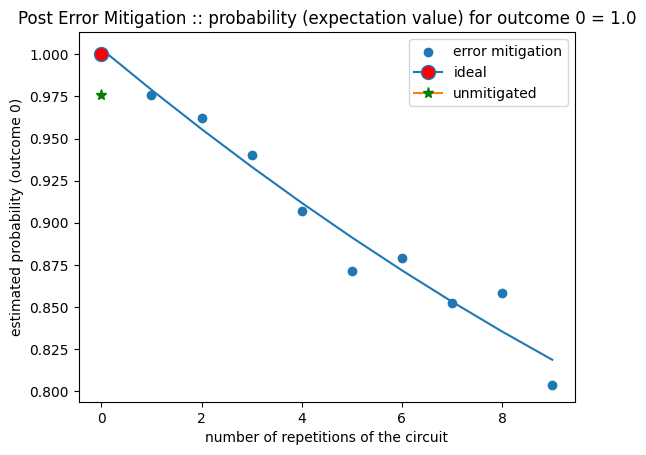

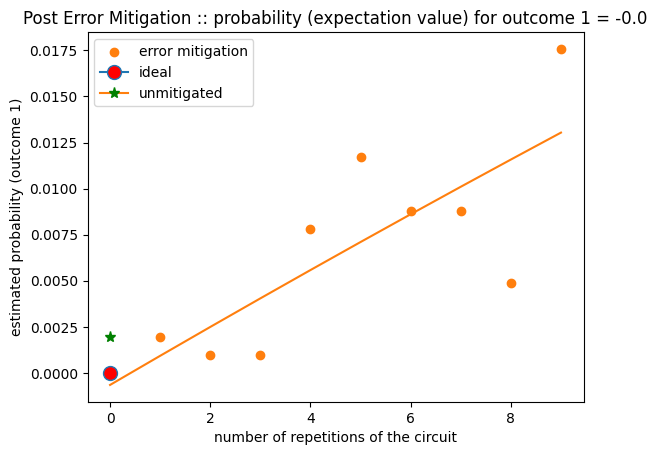

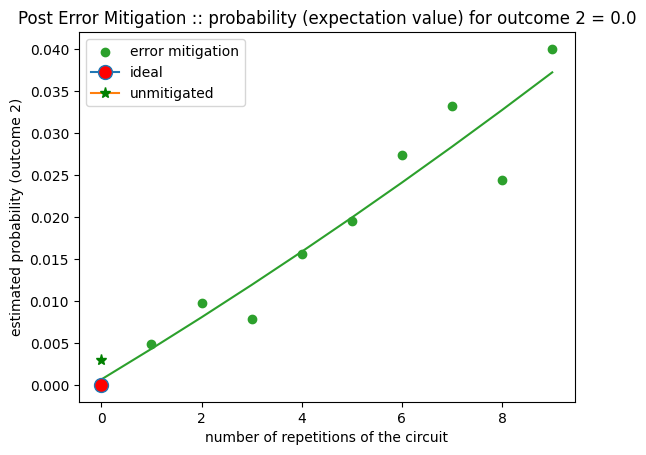

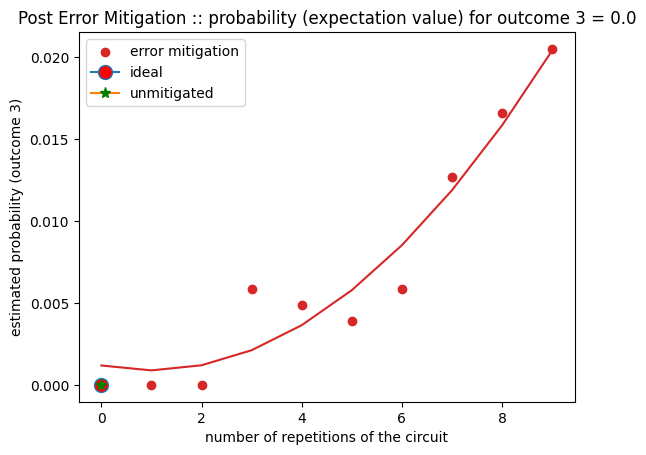

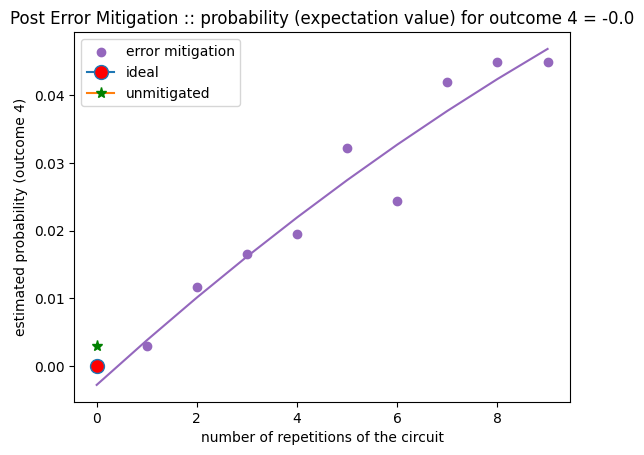

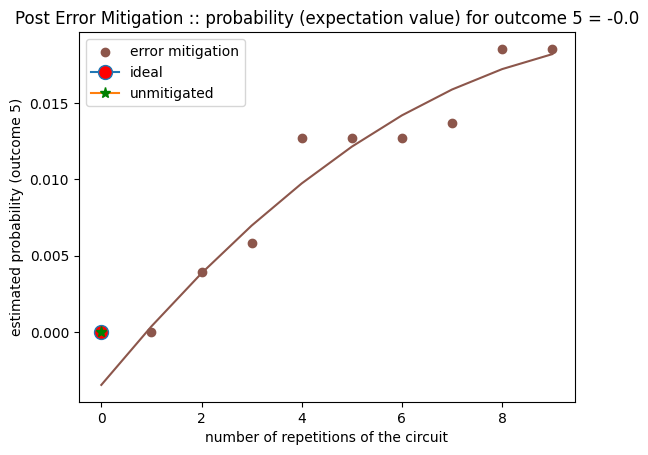

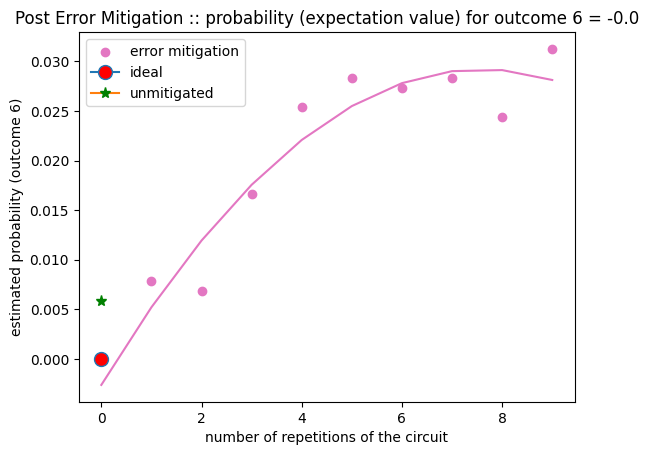

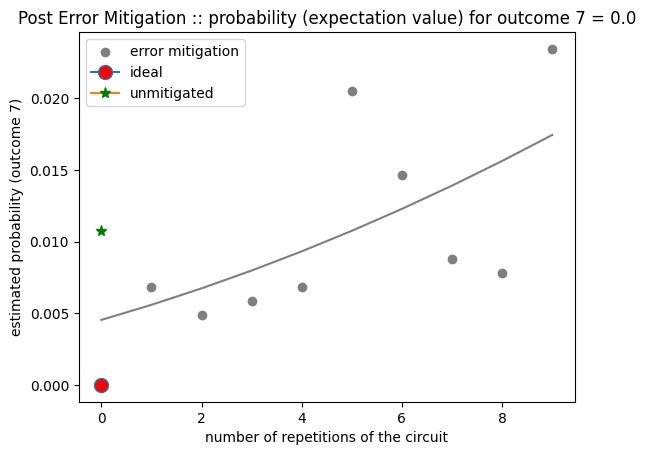

In [16]:
import matplotlib.pyplot as plt

deg = 2

prob_ideal = probabilities(counts_ideal_dict)
prob_unmitigated = probabilities(counts_noise_dict)

def plot(probs, outcome):
    f = np.poly1d(np.polyfit(x=ks, y=probs, deg=deg))
    plt.plot([f(k) for k in range(kmax)], c=f'C{outcome}')

    plt.scatter(ks, probs, c=f'C{outcome}', label="error mitigation")
    plt.plot(0, prob_ideal[outcome], marker="o", markersize=10, markerfacecolor="red", label='ideal')
    plt.plot(0, prob_unmitigated[outcome], marker="*", markersize=8, markeredgecolor="green", markerfacecolor="green", label='unmitigated')
    plt.title(f'Post Error Mitigation :: probability (expectation value) for outcome {outcome} = {round(f(0),2)}')
    plt.ylabel(f'estimated probability (outcome {outcome})')
    plt.xlabel('number of repetitions of the circuit')
    plt.legend()
    plt.show()
    print("\n")
    return

print(f'For depolarising single qubit error p = {p_error_one_qubit} and two qubit = {p_error_two_qubit}')
for outcome in range(dim):
    plot(prob_noise_list[:,outcome], outcome)